In [160]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.datasets import fetch_20newsgroups
import stop_words
import gensim
import nltk
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation
import stop_words
import time
import xml.etree.cElementTree as ET
from nltk.stem.snowball import RussianStemmer 
%matplotlib inline

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
EXCLUDE_SYMBOLS_STR = ''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є',
                               '‹', '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—',
                               '‘', '\x7f', '\xad', '¤', '\xa0'])

In [204]:
regex_puncts = re.compile('[%s]' % re.escape(string.punctuation))
regex_symbs = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_digits = re.compile('[%s]' % re.escape(string.digits))
regex_spaces = re.compile('[%s]' % string.printable + string.whitespace)
regex_emoji = re.compile("["
                         "\U0001F600-\U0001F64F"  # emoticons
                         "\U0001F300-\U0001F5FF"  # symbols & pictographs
                         "\U0001F680-\U0001F6FF"  # transport & map symbols
                         "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                         "]+")
morph = pymorphy2.MorphAnalyzer()

N_TOPICS = 10

---

In [205]:
tree = ET.ElementTree(file="file1.xml")
root = tree.getroot()
articles = []
catalog=root[0][0]
for i in range(50):
    articles.append(catalog[i].text)
catalog=root[0][1]
for i in range(50,100):
    articles.append(catalog[i-50].text)
catalog=root[0][2]
for i in range(100,150):
    articles.append(catalog[i-100].text)
catalog=root[0][3]
for i in range(150,200):
    articles.append(catalog[i-150].text)
articles[50]=articles[49]

In [206]:
data_train=articles
print(len(data_train))

200


### Preprocessing

In [207]:
texts_prep = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', txt) for txt in data_train]

In [208]:
texts_prep = [regex_emoji.sub(' ', txt) for txt in texts_prep]

In [209]:
texts_prep = [regex_puncts.sub(' ', txt) for txt in texts_prep]

In [210]:
texts_prep = [regex_symbs.sub('', txt) for txt in texts_prep]

In [211]:
texts_prep = [regex_digits.sub(' ', txt) for txt in texts_prep]

In [212]:
texts_prep = [regex_spaces.sub(' ', txt) for txt in texts_prep]

In [213]:
texts_prep = [txt.strip().replace('\t', ' ').replace('\n', ' ').lower() for txt in texts_prep]

In [214]:
texts_prep = [re.sub( '\s+', ' ', txt).strip() for txt in texts_prep]

In [215]:
texts_prep[:4]

['американские производители и владельцы оружия активно поддерживали в президентской гонке дональда трампа национальная стрелковая ассоциация nra вложила в его предвыборную кампанию миллионов долларов вскоре после того как трамп встал во главе страны продажи резко пошли вниз а некоторые компании обанкротились на бизнес усиливается давление банки отказываются предоставлять кредиты а крупные фонды бунтуют против инвестиций в оружие вынуждая оружейников ужесточать доступ к собственной продукции крупнокалиберный провал в американской экономике в материале ленты ру кандидат от народа дональд трамп стал первым за тридцать лет президентом сша который открыто поддержал национальную стрелковую ассоциацию nra апреля года на сотый день своего правления он выступил с речью на ее съезде до него последний раз на такое осмеливался рональд рейган в году с самого начала предвыборной гонки nra воспринимала трампа как своего кандидата и активно его поддерживала в частности ассоциация за свои деньги выпус

In [216]:
stops=stop_words.get_stop_words('ru')
wnl = nltk.WordNetLemmatizer()
stemmer = RussianStemmer()

In [217]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\root\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [218]:
corpus = []

for sentence in log_progress(texts_prep[::]):
    tokens = sentence.split(' ')
    tokens = [t for t in tokens if t not in stops]
    #tokens = [wnl.lemmatize(t) for t in tokens if t not in stops]
    tokens = [stemmer.stem(t) for t in tokens if t not in stops]
    tokens = [t for t in tokens if len(t) >= 3]
    corpus.append(tokens)

## LSA

**LSA = TFIDF + SVD**

In [219]:
vectorizer = TfidfVectorizer()

In [220]:
X = vectorizer.fit_transform([' '.join(tokens) for tokens in corpus])

print(X.shape)

(200, 10744)


In [221]:
vectorizer.vocabulary_

{'американск': 698,
 'производител': 7573,
 'владельц': 1471,
 'оруж': 5845,
 'активн': 649,
 'поддержива': 6621,
 'президентск': 7226,
 'гонк': 2094,
 'дональд': 2607,
 'трамп': 9547,
 'национальн': 5074,
 'стрелков': 9198,
 'ассоциац': 813,
 'nra': 321,
 'влож': 1488,
 'предвыборн': 7160,
 'кампан': 3626,
 'доллар': 2593,
 'вскор': 1693,
 'встал': 1708,
 'глав': 2038,
 'стран': 9184,
 'продаж': 7519,
 'резк': 8119,
 'пошл': 7103,
 'некотор': 5207,
 'компан': 3890,
 'обанкрот': 5454,
 'бизнес': 1036,
 'усилива': 9930,
 'давлен': 2241,
 'банк': 891,
 'отказыва': 5970,
 'предоставля': 7172,
 'кредит': 4077,
 'крупн': 4144,
 'фонд': 10128,
 'бунт': 1230,
 'инвестиц': 3407,
 'вынужд': 1819,
 'оружейник': 5847,
 'ужесточа': 9778,
 'доступ': 2663,
 'собствен': 8814,
 'продукц': 7543,
 'крупнокалиберн': 4145,
 'прова': 7474,
 'экономик': 10566,
 'материал': 4537,
 'лент': 4270,
 'кандидат': 3637,
 'народ': 5015,
 'перв': 6267,
 'тридца': 9600,
 'президент': 7225,
 'сша': 9307,
 'открыт': 598

In [222]:
keys = list(vectorizer.vocabulary_.keys())
values = list(vectorizer.vocabulary_.values())

_ind = np.argsort(values)
words_sorted = np.asarray(keys)[_ind]

print(len(keys), len(values), len(words_sorted))

10744 10744 10744


In [223]:
svd = TruncatedSVD(n_components=N_TOPICS, n_iter=10).fit(X) #10

['метр' 'дом' 'жил' 'рубл' 'квартир']
[0.12180254 0.12190021 0.18009856 0.22867155 0.29620845]

['недвижим' 'рубл' 'метр' 'жил' 'квартир']
[0.10299585 0.12613582 0.13139593 0.16406181 0.32594945]

['охотник' 'квартир' 'воен' 'самолет' 'ракет']
[0.10593326 0.1068787  0.10738597 0.13977301 0.16057238]

['бомбардировщик' 'авиац' 'сверхзвуков' 'пак' 'самолет']
[0.11515259 0.11789466 0.12249026 0.14939204 0.23955109]

['величин' 'ядр' 'атмосфер' 'учен' 'каон']
[0.10935834 0.11625344 0.12861883 0.15844827 0.16342701]

['компан' 'samsung' 'смартфон' 'экра' 'телефон']
[0.11993638 0.14431687 0.14741398 0.15233746 0.17855719]

['холецистокинин' 'белк' 'альцгеймер' 'телефон' 'гормон']
[0.11349945 0.1181942  0.1246259  0.12601317 0.1513326 ]

['способств' 'холецистокинин' 'альцгеймер' 'рубл' 'гормон']
[0.12805937 0.13478146 0.14302853 0.14662234 0.17970861]

['узбекиста' 'дворц' 'подвал' 'университет' 'золот']
[0.12523468 0.13130456 0.13340098 0.13708935 0.15309544]

['ракетн' 'украин' 'ктрв' 'рак

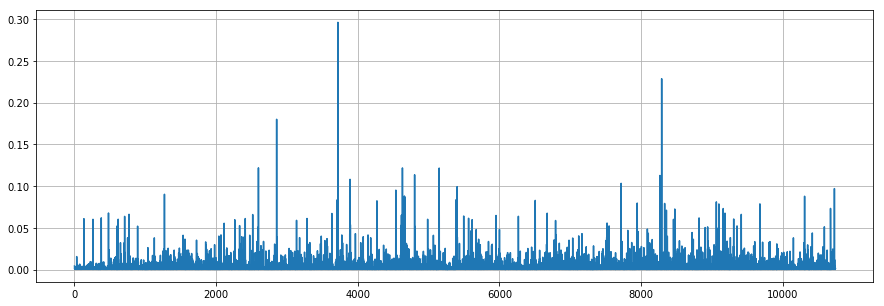

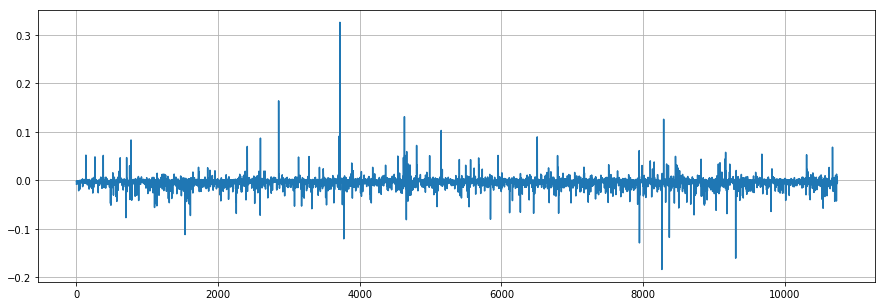

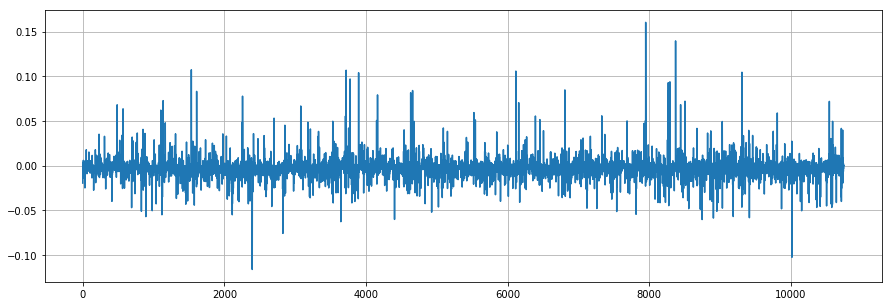

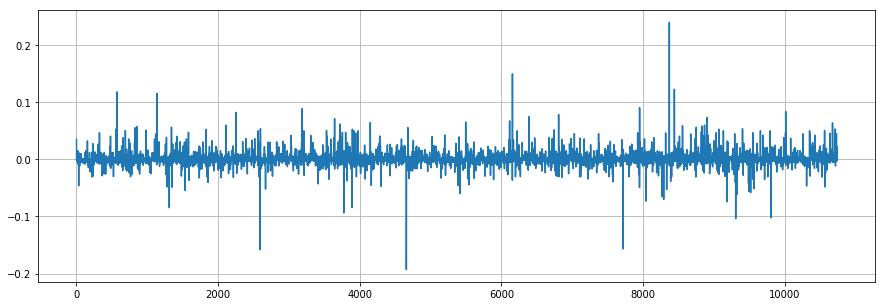

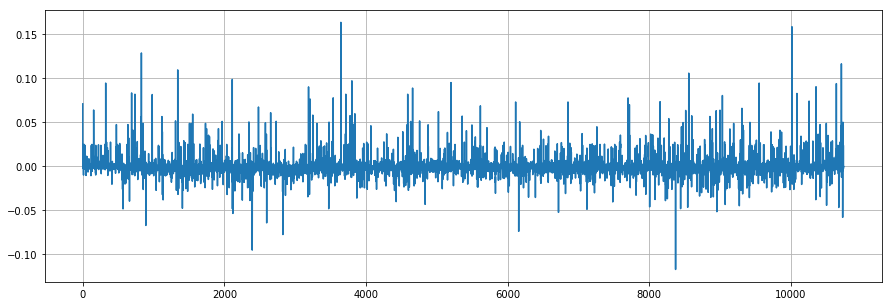

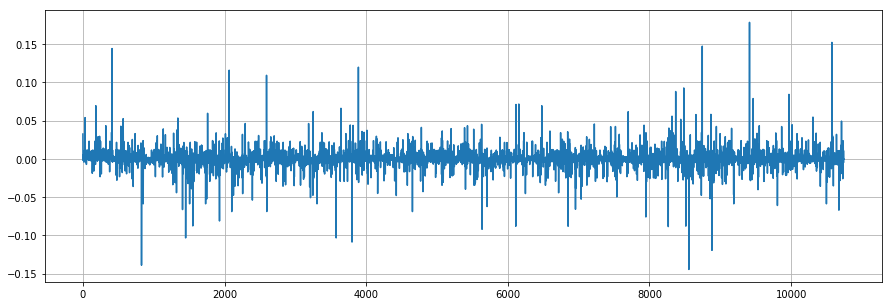

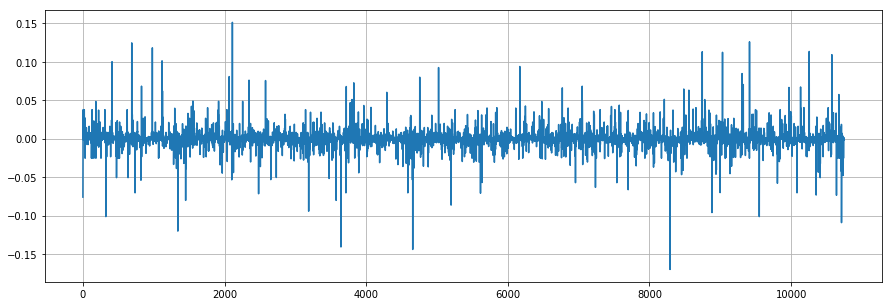

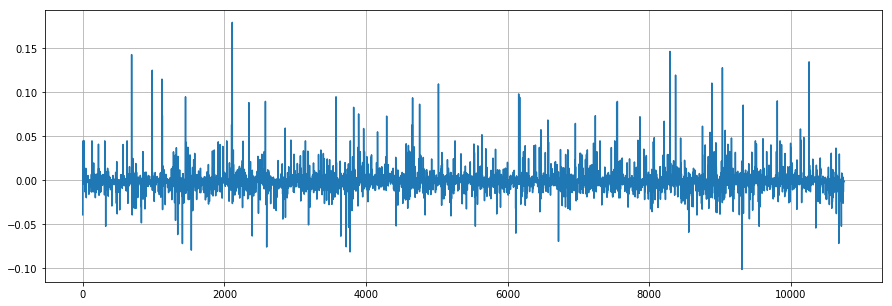

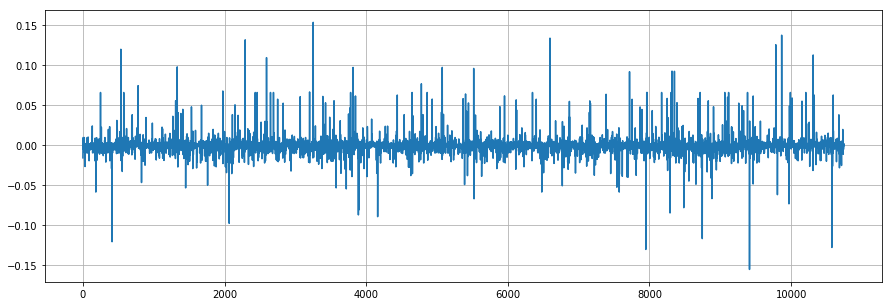

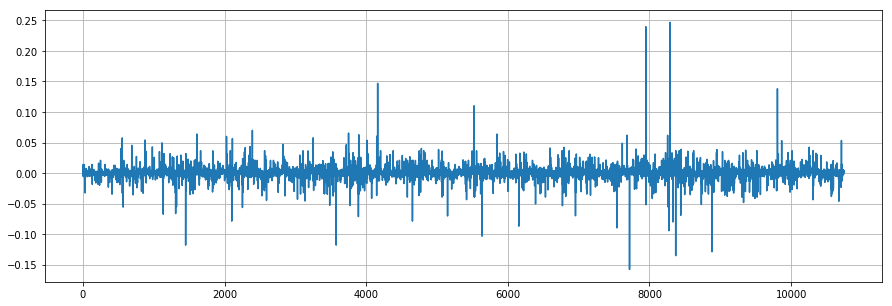

In [224]:
stub = [0] * N_TOPICS

for i in range(N_TOPICS):
    ind = np.argsort(svd.components_[i])[-5:] #10
    print(words_sorted[ind])
    print(np.sort(svd.components_[i])[-5:]) #10
    print()
    
    tmp = stub.copy()
    tmp[i] = 1
    plt.figure(figsize=(15, 5))
    plt.plot(svd.components_[i])
    plt.grid(True)
#     break

### [LSA gensim](https://radimrehurek.com/gensim/models/lsimodel.html)

## LDA

**LDA = LSA + Dirichlet**

### gensim

**[sklearn-like API](https://radimrehurek.com/gensim/sklearn_api/ldaseqmodel.html)**

In [225]:
dictionary = corpora.Dictionary(corpus)

In [226]:
X_bow = [dictionary.doc2bow(text) for text in corpus]

In [227]:
lda_gensim = gensim.models.ldamodel.LdaModel(X_bow, num_topics=N_TOPICS, id2word=dictionary, iterations=10)

In [228]:
lda_gensim.print_topics()

[(0,
  '0.005*"рубл" + 0.005*"росс" + 0.004*"новост" + 0.004*"важн" + 0.003*"лент" + 0.003*"жил" + 0.003*"компан" + 0.003*"тем" + 0.003*"квартир" + 0.003*"стал"'),
 (1,
  '0.005*"росс" + 0.005*"рубл" + 0.004*"квартир" + 0.004*"лент" + 0.003*"важн" + 0.003*"компан" + 0.003*"стран" + 0.003*"материал" + 0.003*"новост" + 0.003*"нов"'),
 (2,
  '0.004*"лент" + 0.004*"квартир" + 0.003*"рубл" + 0.003*"дня" + 0.003*"новост" + 0.003*"стран" + 0.003*"компан" + 0.003*"нов" + 0.003*"росс" + 0.003*"важн"'),
 (3,
  '0.005*"новост" + 0.005*"нов" + 0.005*"квартир" + 0.005*"рубл" + 0.003*"лент" + 0.003*"компан" + 0.003*"росс" + 0.003*"материал" + 0.003*"важн" + 0.003*"январ"'),
 (4,
  '0.006*"росс" + 0.004*"рубл" + 0.004*"лент" + 0.004*"новост" + 0.004*"нов" + 0.004*"квартир" + 0.003*"важн" + 0.003*"материал" + 0.003*"слов" + 0.003*"подписыва"'),
 (5,
  '0.005*"рубл" + 0.005*"квартир" + 0.004*"росс" + 0.004*"новост" + 0.003*"важн" + 0.003*"лент" + 0.003*"жил" + 0.003*"telegr" + 0.003*"материал" + 0.003*

**[multi-core version](https://radimrehurek.com/gensim/models/ldamulticore.html)**

### sklearn

In [229]:
lda_sklearn = LatentDirichletAllocation(n_components=N_TOPICS, max_iter=10, batch_size=10, evaluate_every=1, verbose=1, 
                                        n_jobs=4, learning_method='batch').fit(X)

iteration: 1 of max_iter: 10, perplexity: 1247692.5465
iteration: 2 of max_iter: 10, perplexity: 1111423.8024
iteration: 3 of max_iter: 10, perplexity: 948802.7702
iteration: 4 of max_iter: 10, perplexity: 769958.0564
iteration: 5 of max_iter: 10, perplexity: 645814.2904
iteration: 6 of max_iter: 10, perplexity: 582141.2695
iteration: 7 of max_iter: 10, perplexity: 547081.0258
iteration: 8 of max_iter: 10, perplexity: 524883.2960
iteration: 9 of max_iter: 10, perplexity: 508939.5466
iteration: 10 of max_iter: 10, perplexity: 497582.5500


In [230]:
lda_sklearn.components_.shape

(10, 10744)

In [232]:
stub = [0] * N_TOPICS

for i in range(N_TOPICS):
    ind = np.argsort(lda_sklearn.components_[i])[-10:] #10
    print(words_sorted[ind])
    print(np.sort(svd.components_[i])[-10:]) #10
    print()
#     break

['iphon' 'ауг' 'трат' 'посейдон' 'номинальн' 'сэмюэльсон' 'расход'
 'ленинград' 'блокад' 'ввп']
[0.10335489 0.10814271 0.11276237 0.11360846 0.12163187 0.12180254
 0.12190021 0.18009856 0.22867155 0.29620845]

['мост' 'тизяк' 'соколовск' 'сдач' 'промышлен' 'обнос' 'техосмотр'
 'банковск' 'ктрв' 'украин']
[0.07211661 0.08339108 0.08721097 0.08972647 0.0913984  0.10299585
 0.12613582 0.13139593 0.16406181 0.32594945]

['фотон' 'рейтинг' 'накоп' 'излучен' 'горизонт' 'хокинг' 'частиц' 'окб'
 'недооценен' 'стаж']
[0.09390288 0.09710519 0.09826976 0.104073   0.10463228 0.10593326
 0.1068787  0.10738597 0.13977301 0.16057238]

['дворц' 'блюд' 'золот' 'саун' 'белк' 'растен' 'купюр' 'porsch' 'подвал'
 'университет']
[0.08205068 0.0835258  0.08859649 0.08886965 0.09027072 0.11515259
 0.11789466 0.12249026 0.14939204 0.23955109]

['диск' 'энерг' 'aaj' 'эксперимент' 'спектр' 'звездн' 'ура' 'ogl'
 'транзиент' 'величин']
[0.0943832  0.0949735  0.09694593 0.09857388 0.10566209 0.10935834
 0.11625344 

### [Dynamic topic modeling (gensim)](https://radimrehurek.com/gensim/models/ldaseqmodel.html)